In [1]:
import numpy as np
import math
import re
import pandas as pd
from bs4 import BeautifulSoup

In [2]:
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_datasets as tfds

### Load data

In [3]:
cols = ["sentiment", "id", "date", "query", "user", "text"]
data = pd.read_csv(    
    "./data/training.1600000.processed.noemoticon.csv",
    header=None,
    names=cols,
    engine="python",
    encoding="latin1"
)

In [4]:
data.head()

,sentiment,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


### Data cleaning

In [5]:
data.drop(["id", "date", "query", "user"], # don't forget to run data = train_data before!
          axis=1,
          inplace=True)

In [6]:
def clean_tweet(tweet):
    tweet = BeautifulSoup(tweet, "lxml").get_text()
    # Removing the @
    tweet = re.sub(r"@[A-Za-z0-9]+", ' ', tweet)
    # Removing the URL links
    tweet = re.sub(r"https?://[A-Za-z0-9./]+", ' ', tweet)
    # Keeping only letters
    tweet = re.sub(r"[^a-zA-Z.!?']", ' ', tweet)
    # Removing additional whitespaces
    tweet = re.sub(r" +", ' ', tweet)
    return tweet

In [7]:
data_clean = [clean_tweet(tweet) for tweet in data.text]

C:\Users\yurit\Anaconda3\envs\tf\lib\site-packages\bs4\__init__.py:332: MarkupResemblesLocatorWarning: " i just received my G8 viola exam.. and its... well... .. disappointing.. :\.." looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
C:\Users\yurit\Anaconda3\envs\tf\lib\site-packages\bs4\__init__.py:332: MarkupResemblesLocatorWarning: "E3 ON PLAYSTATION HOME IN ABOUT AN HOUR!!!!!!!!!! \../  \../" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [8]:
data_labels = data.sentiment.values
data_labels[data_labels == 4] = 1

### Tokenization

In [9]:
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    data_clean, target_vocab_size=2**16
)

data_inputs = [tokenizer.encode(sentence) for sentence in data_clean]

### Padding

In [10]:
MAX_LEN = max([len(sentence) for sentence in data_inputs])
data_inputs = tf.keras.preprocessing.sequence.pad_sequences(data_inputs,
                                                            value=0,
                                                            padding="post",
                                                            maxlen=MAX_LEN)

In [11]:
test_idx = np.random.randint(0, 800000, 8000)
test_idx = np.concatenate((test_idx, test_idx+800000))

In [12]:
test_inputs = data_inputs[test_idx]
test_labels = data_labels[test_idx]
train_inputs = np.delete(data_inputs, test_idx, axis=0)
train_labels = np.delete(data_labels, test_idx)

### Model building

In [13]:
class DCNN(tf.keras.Model):
    
    def __init__(self,
                 vocab_size,
                 emb_dim=128,
                 nb_filters=50,
                 FFN_units=512,
                 nb_classes=2,
                 dropout_rate=0.1,
                 training=False,
                 name="dcnn"):
        super(DCNN, self).__init__(name=name)
        
        self.embedding = layers.Embedding(vocab_size,
                                          emb_dim)
        self.bigram = layers.Conv1D(filters=nb_filters,
                                    kernel_size=2,
                                    padding="valid",
                                    activation="relu")
        self.trigram = layers.Conv1D(filters=nb_filters,
                                     kernel_size=3,
                                     padding="valid",
                                     activation="relu")
        self.fourgram = layers.Conv1D(filters=nb_filters,
                                      kernel_size=4,
                                      padding="valid",
                                      activation="relu")
        self.pool = layers.GlobalMaxPool1D() # no training variable so we can
                                             # use the same layer for each
                                             # pooling step
        self.dense_1 = layers.Dense(units=FFN_units, activation="relu")
        self.dropout = layers.Dropout(rate=dropout_rate)
        if nb_classes == 2:
            self.last_dense = layers.Dense(units=1,
                                           activation="sigmoid")
        else:
            self.last_dense = layers.Dense(units=nb_classes,
                                           activation="softmax")
    
    def call(self, inputs, training):
        x = self.embedding(inputs)
        x_1 = self.bigram(x)
        x_1 = self.pool(x_1)
        x_2 = self.trigram(x)
        x_2 = self.pool(x_2)
        x_3 = self.fourgram(x)
        x_3 = self.pool(x_3)
        
        merged = tf.concat([x_1, x_2, x_3], axis=-1) # (batch_size, 3 * nb_filters)
        merged = self.dense_1(merged)
        merged = self.dropout(merged, training)
        output = self.last_dense(merged)
        
        return output

### Application config

In [36]:
VOCAB_SIZE = tokenizer.vocab_size

EMB_DIM = 200
NB_FILTERS = 100
FFN_UNITS = 256
NB_CLASSES = 2#len(set(train_labels))

DROPOUT_RATE = 0.2

BATCH_SIZE = 4*1024 #32
NB_EPOCHS = 5

### Training

In [37]:
Dcnn = DCNN(vocab_size=VOCAB_SIZE,
            emb_dim=EMB_DIM,
            nb_filters=NB_FILTERS,
            FFN_units=FFN_UNITS,
            nb_classes=NB_CLASSES,
            dropout_rate=DROPOUT_RATE)

In [38]:
if NB_CLASSES == 2:
    Dcnn.compile(loss="binary_crossentropy",
                 optimizer="adam",
                 metrics=["accuracy"])
else:
    Dcnn.compile(loss="sparse_categorical_crossentropy",
                 optimizer="adam",
                 metrics=["sparse_categorical_accuracy"])

In [39]:
checkpoint_path = "./ckpt/"

ckpt = tf.train.Checkpoint(Dcnn=Dcnn)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print("Latest checkpoint restored!!")

In [40]:
Dcnn.fit(train_inputs,
         train_labels,
         batch_size=BATCH_SIZE,
         epochs=NB_EPOCHS,
         validation_data=(test_inputs,test_labels))
ckpt_manager.save()

Epoch 1/5
387/387 [==============================] - 71s 182ms/step - loss: 0.4781 - accuracy: 0.7611 - val_loss: 0.3681 - val_accuracy: 0.8356
Epoch 2/5
387/387 [==============================] - 70s 181ms/step - loss: 0.3183 - accuracy: 0.8647 - val_loss: 0.3695 - val_accuracy: 0.8350
Epoch 3/5
387/387 [==============================] - 70s 181ms/step - loss: 0.2204 - accuracy: 0.9145 - val_loss: 0.4287 - val_accuracy: 0.8257- ETA: 20s - loss: 0.2181 - accuracy:  - ETA: 2s - los
Epoch 4/5
387/387 [==============================] - 70s 182ms/step - loss: 0.1357 - accuracy: 0.9512 - val_loss: 0.5194 - val_accuracy: 0.8188
Epoch 5/5
387/387 [==============================] - 70s 182ms/step - loss: 0.0876 - accuracy: 0.9696 - val_loss: 0.6474 - val_accuracy: 0.8176


'./ckpt/ckpt-1'

In [41]:
losses = pd.DataFrame(Dcnnnn.history.history)

<AxesSubplot:>

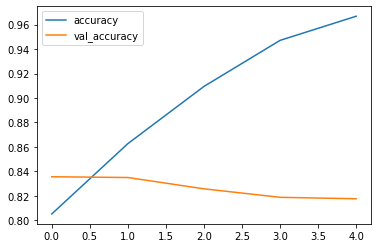

In [42]:
losses[['accuracy','val_accuracy']].plot()

<AxesSubplot:>

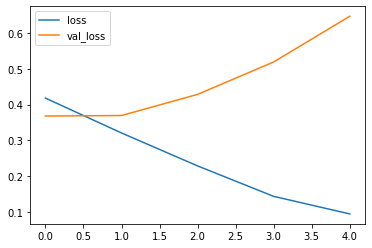

In [43]:
losses[['loss','val_loss']].plot()

### Evaluation

In [44]:
results = Dcnn.evaluate(test_inputs, test_labels, batch_size=BATCH_SIZE)
print(results)

4/4 [==============================] - 0s 51ms/step - loss: 0.6474 - accuracy: 0.8176
[0.6474442481994629, 0.8176249861717224]


In [45]:
test = tf.keras.preprocessing.sequence.pad_sequences(np.array([tokenizer.encode("you are so funny")]),
                                                            value=0,
                                                            padding="post",
                                                            maxlen=MAX_LEN)

Dcnn(test, training=False).numpy()

array([[0.98484]], dtype=float32)

In [46]:
test = tf.keras.preprocessing.sequence.pad_sequences(np.array([tokenizer.encode("you are terrible")]),
                                                            value=0,
                                                            padding="post",
                                                            maxlen=MAX_LEN)

Dcnn(test, training=False).numpy()

array([[0.14901789]], dtype=float32)